# Stock Forecasting using Transformers

In this notebook we implement a Transformer model to forecast stock data.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # https://stackoverflow.com/a/64438413

In [2]:
from __future__ import annotations
import glob
import inspect
import json
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import sys
import tensorflow as tf
import tensorflow.keras as keras

In [3]:
sns.set() # Use seaborn themes.

## Environment Setup

This section contains code that is modifies output path locations, random seed, and logging.

In [4]:
DATASET_ROOT = Path('~/ml/datasets').expanduser()
if not DATASET_ROOT.exists(): raise ValueError(f"Dataset root directory does not exist at {DATASET_ROOT}")
PROJECT_ROOT = Path('~/ml/ece_6524/final_project').expanduser()
CHECKPOINT_ROOT = PROJECT_ROOT / 'checkpoints'
IMAGE_ROOT = PROJECT_ROOT / 'images'
TABLE_ROOT = PROJECT_ROOT / 'tables'

# Ensure some directories exist.
PROJECT_ROOT.mkdir(parents=True, exist_ok=True)
CHECKPOINT_ROOT.mkdir(parents=True, exist_ok=True)
IMAGE_ROOT.mkdir(parents=True, exist_ok=True)
TABLE_ROOT.mkdir(parents=True, exist_ok=True)

In [5]:
# Set random seeds.
SEED = 0
tf.random.set_seed(SEED) # Only this works on ARC (since tensorflow==2.4).

In [6]:
# Setup logging (useful for ARC systems).
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG) # Must be lowest of all handlers listed below.
while logger.hasHandlers(): logger.removeHandler(logger.handlers[0]) # Clear all existing handlers.

# Custom log formatting.
formatter = logging.Formatter('%(asctime)s | %(levelname)s | %(message)s')

# Log to STDOUT (uses default formatting).
sh = logging.StreamHandler(stream=sys.stdout)
sh.setLevel(logging.INFO)
logger.addHandler(sh)

# Set Tensorflow logging level.
tf.get_logger().setLevel('ERROR') # 'INFO'

In [7]:
# Request user for Kaggle login if JSON file does not exist.
kaggle_config_file = Path("~/.kaggle/kaggle.json").expanduser()
if not kaggle_config_file.exists() and os.environ.get("KAGGLE_USERNAME", None) is None and os.environ.get("KAGGLE_KEY", None) is None:
    import json
    import getpass
    entry = getpass.getpass(prompt="Please enter your Kaggle username or JSON blob: ")
    try:
        blob = json.loads(entry)
        os.environ["KAGGLE_USERNAME"] = blob['username']
        os.environ["KAGGLE_KEY"] = blob['key']
    except:
        api_key = getpass.getpass(prompt="Please enter your Kaggle API KEY: ")
        os.environ["KAGGLE_USERNAME"] = entry
        os.environ["KAGGLE_KEY"] = api_key
else:
    logger.info('Kaggle API configured')

Kaggle API configured


In [8]:
# List all GPUs visible to TensorFlow.
gpus = tf.config.list_physical_devices('GPU')
logger.info(f"Num GPUs Available: {len(gpus)}")
for gpu in gpus:
    logger.info(f"Name: {gpu.name}, Type: {gpu.device_type}")

Num GPUs Available: 1
Name: /physical_device:GPU:0, Type: GPU


## Huge Stock Market Dataset from Kaggle

https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs

In [9]:
class HugeStockMarketDataset:
    """Wrapper for Huge Stock Market Dataset by Boris Marjanovic on Kaggle.

    Source URL is: https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs/version/3

    This class can be used like a Python dictionary, where keys are the stock/etf names, and values are
    `pandas.DataFrame` objects corresponding to that stock/etf.
    """
    root = 'HugeStockMarketDataset'

    def __init__(self, 
        path: str,
        files: list = None,
        quiet: bool = False,
        exclude_stocks: bool = False,
        exclude_etfs: bool = False,
        usecols: list[str] = ['Date','Open','High','Low','Close','Volume','OpenInt'],
        ):
        self.exclude_stocks = exclude_stocks
        self.exclude_etfs = exclude_etfs
        self.usecols = usecols
        self._index = {}

        # Download the dataset if necessary.
        newpath = Path(path).expanduser()/self.root
        if not newpath.exists():
            self.download(newpath, files, quiet=quiet)
        else:
            self.path = newpath
            self._build_index()

    def _build_index(self):
        """Creates an internal index of stocks and ETFs for lookup."""

        # Helper function to index a folder of files.
        def _index_folder(dir: Path):
            for file in glob.iglob(str(dir/'*.txt'), recursive=True):
                filename = Path(file).name
                product_name = filename.split('.', maxsplit=1)[0]
                self._index[product_name] = file

        # Index all stocks.
        if not self.exclude_stocks:
            _index_folder(self.path/'**'/'Stocks')
        
        # Index all ETFs.
        if not self.exclude_etfs:
            _index_folder(self.path/'**'/'ETFs')

    def download(self, path: str, files: list = None, quiet: bool = True):
        """Downloads the dataset from Kaggle.

        Args:
            path (str): The path to place the download.
            files (list, optional): Subset list of files to download instead of entire dataset. Defaults to None.
            quiet (bool, optional): Suppress verbose output. Defaults to True.
        """
        import kaggle
        kaggle_dataset = 'borismarjanovic/price-volume-data-for-all-us-stocks-etfs'
        kaggle.api.authenticate()

        # Save the new downloaded path.
        self.path = Path(path).expanduser()

        # Specific file list was given.
        if files is not None:
            for f in files:
                kaggle.api.dataset_download_file(
                    dataset=kaggle_dataset,
                    file_name=f,
                    path=path/f,
                    quiet=quiet,
                )
        # Download all files.
        else:
            kaggle.api.dataset_download_files(
                dataset=kaggle_dataset,
                path=path,
                unzip=True,
                quiet=quiet,
            )

        # Force rebuild the index after downloading.
        logger.info("Building file index")
        self._build_index()

    def get_dataframe(self, 
        key: str,
        **kwargs,
        ) -> pd.DataFrame:
        """Obtain historical data for stock or ETF in a pandas dataframe.

        Optional keyword arguments are passed directly to `pandas.read_csv` function.

        Args:
            key (str): The identifier for the stock or ETF.

        Returns:
            pd.DataFrame: Historical data.
        """
        return pd.read_csv(self._index[key], **kwargs)

    #### Dictionary Override ######

    def __getitem__(self, key):
        if isinstance(key, str):
            return self.get_dataframe(key, usecols=self.usecols)
        elif isinstance(key, list):
            return [self.get_dataframe(asset, usecols=self.usecols) for asset in key]

    def __delitem__(self, key):
        del self._index[key]

    def __iter__(self):
        return iter(self._index)

    def items(self):
        for key in self:
            yield key, self.get_dataframe(key, usecols=self.usecols)

    def __len__(self):
        return len(self._index)

    def keys(self):
        """Returns a list of all downloaded stocks and ETFs."""
        return self._index.keys()

    ###############################

In [10]:
# Inspiration: https://www.tensorflow.org/tutorials/structured_data/time_series#data_windowing
class WindowGenerator:
    def __init__(self,
        in_seq_len: int,
        out_seq_len: int,
        shift: int,
        train_df: pd.DataFrame,
        val_df: pd.DataFrame,
        test_df: pd.DataFrame,
        in_feat: list[str] = None,
        out_feat: list[str] = None,
        batch_size: int = 32,
        shuffle: bool = True,
        ):
        """Constructs sliding windows of sequential data.

        Data must already be split into train/val/test subsets,
        and provided as `pandas.DataFrame` objects.

        Args:
            in_seq_len (int): Input sequence length.
            out_seq_len (int): Output (target) sequence length.
            shift (int): Number of indices to skip between elements when traversing window.
            train_df (pd.DataFrame): Training data frame.
            val_df (pd.DataFrame): Validation data frame.
            test_df (pd.DataFrame): Testing data frame.
            in_feat (list[str], optional): Desired subset of input features for window. Defaults to None.
            out_feat (list[str], optional): Desired subset of output features for window. Defaults to None.
            batch_size (int, optional): Batch size. Defaults to 32.
            shuffle (bool, optional): Shuffle windows prior to batching. Defaults to True.
        """
        self.batch_size = batch_size
        self.shuffle = shuffle

        # Preserve dataframes.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Preserve sequence information.
        self.in_seq_len = in_seq_len
        self.out_seq_len = out_seq_len
        self.shift = shift
        self.total_window_len = in_seq_len + shift

        # Setup indexing slices for window extraction.
        self.in_slice = slice(0, self.in_seq_len)
        self.out_slice = slice(self.total_window_len - self.out_seq_len, None)
        self.in_idx = np.arange(self.total_window_len)[self.in_slice]
        self.out_idx = np.arange(self.total_window_len)[self.out_slice]

        # Setup train/val/test column extractors.
        self.col2idx = {name: i for i, name in enumerate(train_df.columns)}
        if in_feat is not None:
            self.in_feat = in_feat
            self.in_col_idx = [self.col2idx[col] for col in in_feat]
        else:
            self.in_col_idx = list(range(len(train_df.columns)))
            self.in_feat = [train_df.columns[i] for i in self.in_col_idx]
        if out_feat is not None:
            self.out_feat = out_feat
            self.out_col_idx = [self.col2idx[col] for col in out_feat]
        else:
            self.out_col_idx = list(range(len(train_df.columns)))
            self.out_feat = [train_df.columns[i] for i in self.out_col_idx]

    def __repr__(self):
        """String representation of class."""
        return '\n'.join([
            f"Total window length: {self.total_window_len}",
            f"Input indices: {self.in_idx}",
            f"Output indices: {self.out_idx}",
            f"Input features: {self.in_feat}",
            f"Output features: {self.out_feat}",
        ])

    def split_window(self, 
        window: tf.Tensor, # window shape is (batch, seq, feat)
        ) -> tuple[tf.Tensor, tf.Tensor]:
        """Splits a single window of data into input/output seqments.

        Args:
            window (tf.Tensor): Tensor of window data with shape (batch, seq, feat).

        Returns:
            tuple[tf.Tensor, tf.Tensor]: 2-tuple of input/output data segments, where the shapes are:
                - Input window: (batch, in_seq_len, in_feat)
                - Output window: (batch, out_seq_len, out_feat)
        """
        # Decompose input/output sequence from given input window.
        in_seq = tf.stack([window[:, self.in_slice, i] for i in self.in_col_idx], axis=-1)
        out_seq = tf.stack([window[:, self.out_slice, i] for i in self.out_col_idx], axis=-1)

        # Set shape for input/output sequences.
        # Note that dimensions set to `None` are not updated.
        in_seq = tf.ensure_shape(in_seq, (None, self.in_seq_len, None))
        out_seq = tf.ensure_shape(out_seq, (None, self.out_seq_len, None))

        return in_seq, out_seq

    def make_dataset(self, 
        df: pd.DataFrame,
        batch_size: int = 32,
        shuffle: bool = True,
        ) -> tf.data.Dataset:
        """Construct a TensorFlow Dataset from given input data frame.

        Datasets load tuples of batched input/output windows with shapes:
            - Input window: (batch, in_seq_len, in_feat)
            - Output window: (batch, out_seq_len, out_feat)

        Note that output windows are generally target sequences.

        Args:
            df (pd.DataFrame): Source data frame.
            batch_size (int, optional): Batch size. Defaults to 32.
            shuffle (bool, optional): Shuffle windows prior to batching. Defaults to True.

        Returns:
            tf.data.Dataset: Dataset object.
        """

        # Convert data frame into numpy matrix.
        data = df.to_numpy()

        # Convert data matrix into TensorFlow dataset.
        # dataset = keras.utils.timeseries_dataset_from_array(
        dataset = keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_len,
            sequence_stride=self.shift,
            shuffle=shuffle,
            batch_size=batch_size,
        )

        # Pipe the raw dataset into the window splitting function.
        dataset = dataset.map(self.split_window)

        # Return the dataset.
        return dataset

    @property
    def train(self):
        """Training dataset."""
        return self.make_dataset(
            df=self.train_df,
            batch_size=self.batch_size,
            shuffle=self.shuffle,
        )

    @property
    def val(self):
        """Validation dataset."""
        return self.make_dataset(
            df=self.val_df,
            batch_size=self.batch_size,
            shuffle=self.shuffle,
        )

    @property
    def test(self):
        """Testing dataset."""
        return self.make_dataset(
            df=self.test_df,
            batch_size=self.batch_size,
            shuffle=self.shuffle,
        )

In [11]:
def load_stock_dataset(
    asset: str,
    in_seq_len: int,
    out_seq_len: int,
    shift: int,
    split: tuple[float, float, float], # must sum to 1.
    in_feat: list[str] = ['Open','High','Low','Close','Volume'],
    out_feat: list[str] = ['Open','High','Low','Close','Volume'],
    batch_size: int = 32,
    shuffle: bool = True,
    normalize: bool = True,
    return_datasets: bool = True,
    return_df: bool = False,
    return_window: bool = False,
    ) -> None|tuple:
    """Load the history for a single stock within the Huge Stock Market Dataset.

    Args:
        asset (str): Name of stock or ETF to use.
        in_seq_len (int): Input sequence length for window.
        out_seq_len (int): Output (target) sequence length for window.
        shift (int): Number of indices to skip when generating window.
        split (tuple[float, float, float]): Tuple of `(train, val, test)` splits. Note that these must sum to `1`.
        in_feat (list[str], optional): Desired subset of input features for window. Defaults to `['Open','High','Low','Close','Volume']`.
        out_feat (list[str], optional): Desired subset of output features for window. Defaults to `['Open','High','Low','Close','Volume']`.
        batch_size (int, optional): Batch size. Defaults to 32.
        shuffle (bool, optional): Shuffle windows prior to batching. Defaults to True.
        normalize (bool, optional): Normalize the data using mean/std method. Defaults to `True`.
        return_datasets (bool, optional): Return train/val/test datasets. Defaults to `True`.
        return_df (bool, optional): Return original data frame. Defaults to `False`.
        return_window (bool, optional): Return window generator. Defaults to `False`.

    Returns:
        None|tuple: Several return options:
            - `return_datasets=False`, `return_df=False`, `return_window=False`: Returns None.
            - `return_datasets=True`, `return_df=False`, `return_window=False`: Returns tuple of `(train, val, test)` datasets.
            - `return_datasets=False`, `return_df=True`, `return_window=False`: Returns the original dataset `df`.
            - `return_datasets=False`, `return_df=False`, `return_window=True`: Returns the window generator `windowgen`.
            - `return_datasets=True`, `return_df=True`, `return_window=False`: Returns tuple of `((train, val, test), df)`
            - `return_datasets=True`, `return_df=False`, `return_window=True`: Returns tuple of `((train, val, test), windowgen)`
            - `return_datasets=False`, `return_df=True`, `return_window=True`: Returns tuple of `(windowgen, df)`
            - `return_datasets=True`, `return_df=True`, `return_window=True`: Returns tuple of `((train, val, test), df, windowgen)`
    """
    np.testing.assert_almost_equal(sum(split), 1., err_msg='Split must sum to 1.')
    train_split, _, test_split = split

    # Get dataframe for desired asset.
    dataset = HugeStockMarketDataset(DATASET_ROOT, usecols=['Date','Open','High','Low','Close','Volume'])
    df = dataset[asset]

    # Split dataframe into train/val/test dataframes.
    # Inspiration: https://www.tensorflow.org/tutorials/structured_data/time_series#split_the_data
    n = len(df.index) # Total number of data records.
    df_train = df[:int(n*train_split)].copy()
    df_val = df[int(n*train_split):int(n*(1-test_split))].copy()
    df_test = df[int(n*(1-test_split)):].copy()

    # Drop the 'Date' column, so that we only use the floating-point columns.
    df_train.drop(columns=['Date'], inplace=True, errors='ignore')
    df_val.drop(columns=['Date'], inplace=True, errors='ignore')
    df_test.drop(columns=['Date'], inplace=True, errors='ignore')

    # Normalize the datasets using train-data statistics.
    # Note that only the training data is used for statistics.
    # Inspiration: https://www.tensorflow.org/tutorials/structured_data/time_series#normalize_the_data
    if normalize:
        train_mean = df_train.mean()
        train_std = df_train.std()
        df_train = (df_train - train_mean)/train_std
        df_val = (df_val - train_mean)/train_std
        df_test = (df_test - train_mean)/train_std

    # Build window generator for datasets.
    w = WindowGenerator(
        in_seq_len=in_seq_len,
        out_seq_len=out_seq_len,
        shift=shift,
        train_df=df_train,
        val_df=df_val,
        test_df=df_test,
        in_feat=in_feat,
        out_feat=out_feat,
        batch_size=batch_size,
        shuffle=shuffle,
    )

    # Extract elements for result list.
    result = []
    # Extract train/val/test datasets and return.
    if return_datasets:
        result.append((w.train, w.val, w.test))
    # Extract the data frame.
    if return_df:
        result.append((df, df_train, df_val, df_test))
    # Extract the window generator.
    if return_window:
        result.append(w)

    # Return None if nothing was selected to return.
    if len(result) == 0:
        return None
    # Return single element.
    elif len(result) == 1:
        return result[0]
    # Return entire tuple of results.
    else:
        return tuple(result)

Now lets actually load the dataset. In this case, we're only looking at the `aapl` stock.

Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127]
Output indices: [128]
Input features: ['Open', 'High', 'Low', 'Close', 'Volume']
Output features: ['Open', 'High', 'Low', 'Close', 'Volume']> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

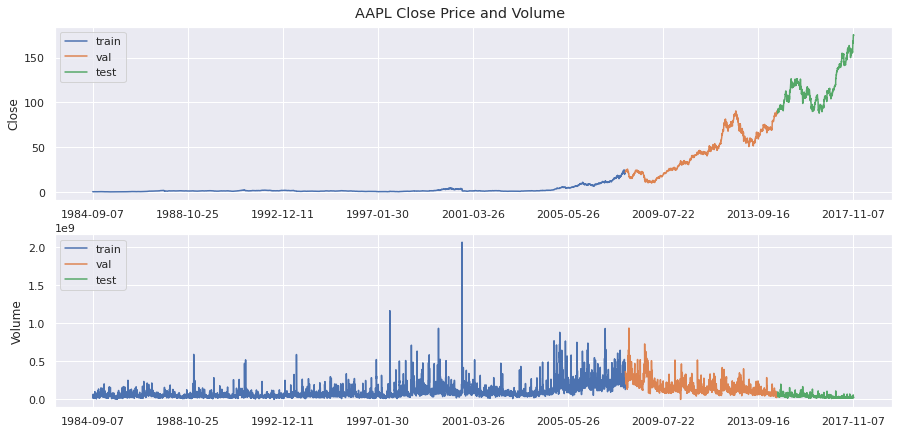

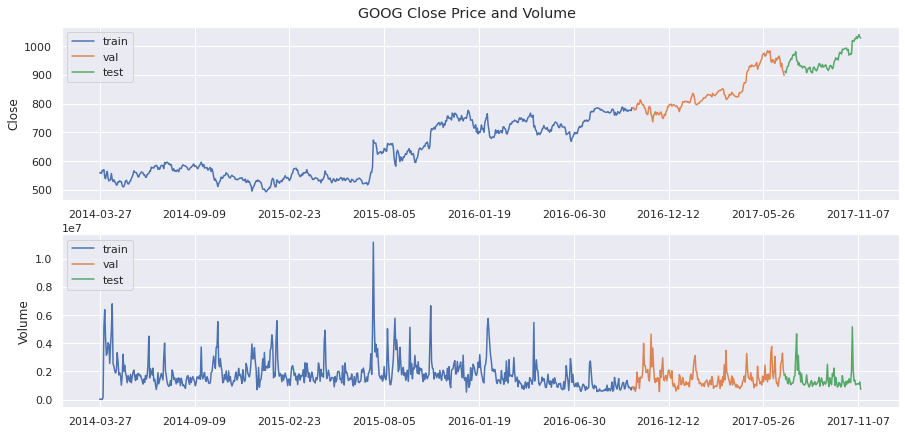

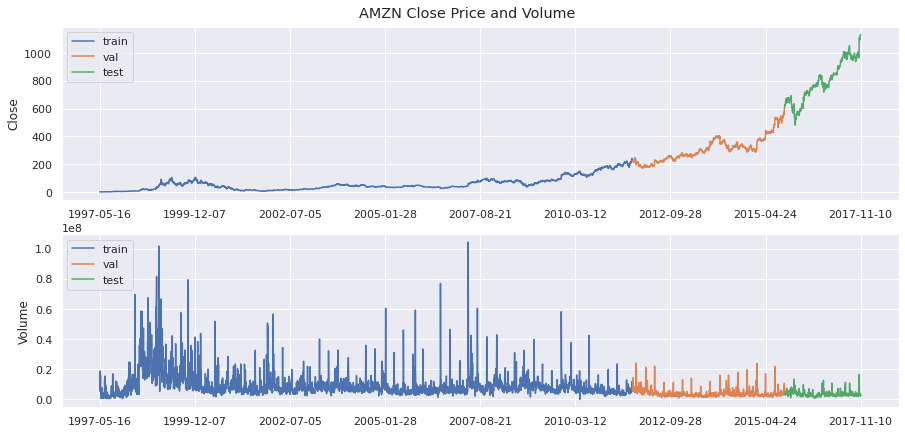

In [12]:
for asset in ['aapl', 'goog', 'amzn']:
    (dataset_train, dataset_val, dataset_test), (df, df_train, df_val, df_test) = load_stock_dataset(
        asset=asset,
        in_seq_len=128,
        out_seq_len=1,
        shift=1,
        split=(0.7, 0.2, 0.1),
        shuffle=False,
        normalize=False,
        return_datasets=True,
        return_df=True,
    )
    # print(f"{dataset_train.element_spec=}")
    # print(f"{dataset_val.element_spec=}")
    # print(f"{dataset_test.element_spec=}")

    fig = plt.figure(figsize=(15,7))
    fig.suptitle(f'{asset.upper()} Close Price and Volume').set_y(0.92)

    n = len(df.index)//8 # Number of date record ticks on X-axis.

    ax = fig.add_subplot(211)
    ax.plot(df_train['Close'], label='train')
    ax.plot(df_val['Close'], label='val')
    ax.plot(df_test['Close'], label='test')
    ax.set_ylabel('Close')
    ax.set_xticks(range(0, df.shape[0], n))
    ax.set_xticklabels(df['Date'].loc[::n])
    ax.legend(loc='upper left')

    ax = fig.add_subplot(212)
    ax.plot(df_train['Volume'], label='train')
    ax.plot(df_val['Volume'], label='val')
    ax.plot(df_test['Volume'], label='test')
    ax.set_ylabel('Volume')
    ax.set_xticks(range(0, df.shape[0], n))
    ax.set_xticklabels(df['Date'].loc[::n])
    ax.legend(loc='upper left')

## Time2Vec Embedding

https://arxiv.org/abs/1907.05321

In [13]:
class Time2Vec(keras.layers.Layer):
    def __init__(self, embed_dim: int, activation: str = 'sin', **kwargs):
        """Vector embedding representation of time.

        Based on the original concept proposed by Kazemi et al., 2019 (https://arxiv.org/abs/1907.05321).

        This layer operates on a single time step with N feature dimensions. When using this layer for multi-time-step
        datasets, you must pass this layer through a `keras.layers.TimeDistributed` layer to multiplex this for all time steps.

        Note that embedding is done on a per-feature basis. For example, using an input record with 7 features (i.e., shape=(1, 7))
        and an embeddding dimension of 10, the resulting embedding would have 70 dimensions (i.e., shape=(1, 70)). This is because
        each of the 7 features gets a 10-dimensional embedding.

        Args:
            embed_dim (int): Length of the time embedding vector.
            activation (str, optional): Periodic activation function. Possible values are ['sin', 'cos']. Defaults to 'sin'.
        """
        super().__init__(**kwargs)
        self.embed_dim = embed_dim # Embed dimension is k+1.
        self.activation = activation.lower() # Convert to lower-case.

        # Set periodic activation function.
        if self.activation.startswith('sin'):
            self.activation_func = tf.sin
        elif self.activation.startswith('cos'):
            self.activation_func = tf.cos
        else:
            raise ValueError(f'Unsupported periodic activation function "{activation}"')

    def build(self, input_shape: list[int]):

        # Weight and bias term for linear portion (i = 0)
        # of embedding.
        self.w_linear = self.add_weight(
            name='w_linear',
            shape=(input_shape[1],),
            initializer='uniform',
            trainable=True,
        )
        self.b_linear = self.add_weight(
            name='b_linear',
            shape=(input_shape[1],),
            initializer='uniform',
            trainable=True,
        )

        # Weight and bias terms for the periodic
        # portion (1 <= i <= k) of embedding.
        self.w_periodic = self.add_weight(
            name='w_periodic',
            shape=(1, input_shape[1], self.embed_dim-1,),
            initializer='uniform',
            trainable=True,
        )
        self.b_periodic = self.add_weight(
            name='b_periodic',
            shape=(1, input_shape[1], self.embed_dim-1,),
            initializer='uniform',
            trainable=True,
        )

    def call(self, x: tf.Tensor) -> tf.Tensor:
        """Embed input into linear and periodic feature components.

        Args:
            x (tf.Tensor): Input tensor with shape (sequence_length, feature_size)

        Returns:
            tf.Tensor: Output tensor with shape (sequence_length, feature_size * embed_dim)
        """
        # Linear term (i = 0).
        embed_linear = self.w_linear * x + self.b_linear
        embed_linear = tf.expand_dims(embed_linear, axis=-1) # Reshape to (sequence_length, feature_size, 1)

        # Periodic terms (1 <= i <= k).
        inner = keras.backend.dot(x, self.w_periodic) + self.b_periodic
        embed_periodic = self.activation_func(inner) # (sequence_length, feature_size, embed_dim - 1)

        # Return concatenated linear and periodic features.
        ret = tf.concat([embed_linear, embed_periodic], axis=-1) # (sequence_length, feature_size, embed_dim)
        ret = tf.reshape(ret, (-1, x.shape[1]*self.embed_dim)) # (sequence_length, feature_size * embed_dim)
        return ret

    def compute_output_shape(self, input_shape: tf.TensorShape) -> tf.TensorShape:
        """Determines the output shape for a given input shape.

        Args:
            input_shape (tf.TensorShape): Input shape (sequence_length, feature_size).

        Returns:
            tf.TensorShape: Output shape (sequence_length, feature_size * embed_dim).
        """
        return tf.TensorShape((input_shape[0], input_shape[1]*self.embed_dim))

    def get_config(self) -> dict:
        """Retreive custom layer configuration for future loading.

        Returns:
            dict: Configuration dictionary.
        """
        config = super().get_config().copy()
        config.update({
            'embed_dim': self.embed_dim,
            'activation': self.activation,
        })
        return config


# Update custom objects dictionary.
keras.utils.get_custom_objects()['Time2Vec'] = Time2Vec



stock_feat = 7
seq_len = 128
embed_dim = 10
inp = keras.Input(shape=(seq_len, stock_feat))
logger.info(f"{inp.shape=}")
x = keras.layers.TimeDistributed(Time2Vec(embed_dim))(inp)
logger.info(f"{x.shape=}")
x = keras.layers.Concatenate(axis=-1)([inp, x])
logger.info(f"{x.shape=}")

inp.shape=TensorShape([None, 128, 7])
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
x.shape=TensorShape([None, 128, 70])
x.shape=TensorShape([None, 128, 77])


## Transformer Architecture

https://arxiv.org/abs/1706.03762

### Attention Layers

Currently uses attention layers provided by TensorFlow. See https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention.

### Transformer Encoder Layer

https://www.tensorflow.org/text/tutorials/transformer#encoder_layer

In [14]:
class TransformerEncoderLayer(keras.layers.Layer):
    def __init__(self,
        d_k: int,
        d_v: int,
        n_heads: int,
        d_ff: int,
        dropout: float = 0.0,
        **kwargs,
        ):
        """Transformer encoder layer.

        Based on the original concept proposed by Vaswani et al., 2017 (https://arxiv.org/abs/1706.03762).

        Args:
            d_k (int): Key dimension (also used for Query dimension).
            d_v (int): Value dimension.
            n_heads (int): Number of attention heads.
            d_ff (int): Dimension of the feed forward sublayer.
            dropout (float, optional): Dropout rate. Defaults to 0.0.
        """
        super().__init__(**kwargs)
        self.d_k = d_k # Query and Key have same dimension.
        self.d_v = d_v
        self.n_heads = n_heads # Number of attention heads.
        self.d_ff = d_ff
        self.dropout = dropout

    def build(self, input_shape: tuple[tf.TensorShape,tf.TensorShape,tf.TensorShape]):

        # First sublayer.
        # Multi-head attention with add and norm.
        self.attn_multi = keras.layers.MultiHeadAttention(
            num_heads=self.n_heads,
            key_dim=self.d_k,
            value_dim=self.d_v,
        )
        self.attn_multi._build_from_signature(*input_shape)
        self.attn_dropout = keras.layers.Dropout(rate=self.dropout)
        self.attn_add = keras.layers.Add()
        # self.attn_norm = keras.layers.LayerNormalization(epsilon=1e-6)
        self.attn_norm = keras.layers.BatchNormalization()

        # Second sublayer.
        # Point-wise feed forward network with add and norm.
        d_query_feat = input_shape[0][-1] # Query feature size.
        self.ff_dense_1 = keras.layers.Dense(units=self.d_ff, activation='gelu')
        self.ff_dense_2 = keras.layers.Dense(units=d_query_feat)
        self.ff_dropout = keras.layers.Dropout(rate=self.dropout)
        self.ff_add = keras.layers.Add()
        # self.ff_norm = keras.layers.LayerNormalization(epsilon=1e-6)
        self.ff_norm = keras.layers.BatchNormalization()

    def call(self, x: tuple[tf.Tensor,tf.Tensor,tf.Tensor]) -> tf.Tensor:
        """Encode input using multi-head self-attention mechanisms.

        Args:
            x (tf.Tensor): Tuple of Query, Value, and Key tensors. Note that the Key tensor is optional, if omitted the Value tensor will be used for both Key and Value.

        Returns:
            tf.Tensor: Output tensor with shape (batch_size, sequence_length, embed_dim + 1)
        """
        # x = (query, value, key)
        # note that "key" is optional.

        # First, do the attention sublayer.
        x_attn = self.attn_multi(*x) # Unpack input as Query, Value, and optional Key.
        x_attn = self.attn_dropout(x_attn)
        x_attn = self.attn_add([x[0], x_attn]) # (residual) Add Query matrix with result of attention layer.
        x_attn = self.attn_norm(x_attn) # Normalize the residual.

        # Second, do the feed forward sublayer.
        x_ff = self.ff_dense_1(x_attn)
        x_ff = self.ff_dense_2(x_ff)
        x_ff = self.ff_dropout(x_ff)
        x_ff = self.ff_add([x_attn, x_ff])
        x_ff = self.ff_norm(x_ff)

        # Return output of feed forward sublayer.
        return x_ff

    def get_config(self) -> dict:
        """Retreive custom layer configuration for future loading.

        Returns:
            dict: Configuration dictionary.
        """
        config = super().get_config().copy()
        config.update({
            'n_heads': self.n_heads,
            'd_k': self.d_k,
            'd_v': self.d_v,
            'd_ff': self.d_ff,
            'dropout': self.dropout,
        })
        return config

# Update custom objects dictionary.
keras.utils.get_custom_objects()['TransformerEncoderLayer'] = TransformerEncoderLayer



# stock_feat = 5
# seq_len = 128
# embed_dim = 32
# d_k = 512
# d_v = 256
# n_heads = 8
# d_ff = 2048
# inp = keras.Input(shape=(seq_len, stock_feat))
# logger.info(f"{inp.shape=}")
# x = keras.layers.TimeDistributed(Time2Vec(embed_dim))(inp)
# logger.info(f"Time2Vec {x.shape=}")
# x = keras.layers.Concatenate(axis=-1)([inp, x])
# logger.info(f"Concatenate {x.shape=}")
# x = TransformerEncoderLayer(d_k, d_v, n_heads, d_ff)([x, x, x])
# logger.info(f"TransformerEncoderLayer {x.shape=}")
# x = TransformerEncoderLayer(d_k, d_v, n_heads, d_ff)([x, x, x])
# logger.info(f"TransformerEncoderLayer {x.shape=}")
# x = TransformerEncoderLayer(d_k, d_v, n_heads, d_ff)([x, x, x])
# logger.info(f"TransformerEncoderLayer {x.shape=}")
# x = keras.layers.GlobalAvgPool1D(data_format='channels_first')(x)
# logger.info(f"GlobalAvgPool1D {x.shape=}")

### Model Definition

In [15]:
def build_transformer(
    in_seq_len: int,
    in_feat: int,
    out_feat: int,
    fc_units: list[int], # list of fully-connected dimensions before classifier.
    embed_dim: int,
    d_k: int,
    d_v: int,
    n_heads: int,
    d_ff: int,
    dropout: float = 0.0,
    n_encoders: int = 3,
    ):

    # Input sequence of features.
    inp = keras.Input(shape=(in_seq_len, in_feat))
    # Time embedding.
    x = keras.layers.TimeDistributed(Time2Vec(embed_dim))(inp)
    # Combine input with embedding to form attention input features.
    x = keras.layers.Concatenate(axis=-1)([inp, x])
    # Pass combined featured through cascaded self-attention encoder sublayers.
    for _ in range(n_encoders):
        x = TransformerEncoderLayer(
            d_k=d_k,
            d_v=d_v,
            n_heads=n_heads,
            d_ff=d_ff,
            dropout=dropout,
        )((x, x, x)) # (query, value, key)
    # Downsample to the original sequence dimension.
    x = keras.layers.GlobalAvgPool1D(data_format='channels_first')(x) # shape=(in_seq_len,)
    x = keras.layers.Dropout(rate=dropout)(x)
    # Fully-connected network before classifier.
    for units in fc_units: 
        x = keras.layers.Dense(units=units, activation='relu')(x)
        x = keras.layers.Dropout(rate=dropout)(x)
    # Classifier.
    x = keras.layers.Dense(units=out_feat, activation='linear')(x)

    # Construct model class and return.
    return keras.Model(inputs=inp, outputs=x)


kwargs = dict(
    in_seq_len=128, # Number of days in the past.
    in_feat=5, # Number of features for each day in the past.
    out_feat=3, # Number of features on 1-day horizon.
    fc_units=[64,64],
    embed_dim=32,
    d_k=512,
    d_v=256,
    n_heads=8,
    d_ff=512,
)
model = build_transformer(**kwargs)
model.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 5)]     0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 128, 160)     320         input_2[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 128, 165)     0           input_2[0][0]             

## Generalized Model Training and Evaluation

In [16]:
def build_model_from_hparams(func):
    """Generalized model build and compile from hyperparameters."""
    def wrapper(hparams: dict, compile_params: dict):
        """Builds model using given hyperparameters for both model and optimizer, and compile parameters for compilation."""
        # Extract paramters needed for the model.
        model_params = {k: hparams[k] for k in inspect.signature(func).parameters if k in hparams}
        # Build model.
        model = func(**model_params)
        # Configure optimizer.
        optim = keras.optimizers.get({'class_name': hparams['optim'], 'config': {'lr':hparams['lr']}})
        # Compile the model.
        model.compile(optimizer=optim, loss=compile_params['loss'], metrics=compile_params['metrics'])
        return model
    return wrapper



# builder = build_model_from_hparams(build_transformer)
# hparams = dict(
#     in_seq_len=128, # Number of days in the past.
#     in_feat=5, # Number of features for each day in the past.
#     out_feat=3, # Number of features on 1-day horizon.
#     fc_units=[64,64],
#     embed_dim=32,
#     d_k=512,
#     d_v=256,
#     n_heads=8,
#     d_ff=512,
#     optim='adam',
#     lr=0.001,
# )
# compile_params = dict(
#     loss='mse',
#     metrics=['mae', 'mape'],
# )
# model = builder(hparams, compile_params)
# model.summary()

In [17]:
def load_metrics(metrics_path: str):
    """Load model metrics from file."""
    with open(metrics_path, 'r') as f:
        return json.load(f)

def load_history(history_path: str):
    """Load model history from file."""
    return pd.read_csv(history_path)

def load_trained_model(
    checkpoint_path: str,
    ) -> tuple[keras.models.Model]:
    """Helper to load a saved model."""
    model = keras.models.load_model(
        checkpoint_path, 
        custom_objects=keras.utils.get_custom_objects(),
    )
    return model

In [18]:
def train_evaluate_model(
    model,
    model_name: str,
    datagen_train: tf.data.Dataset,
    datagen_val: tf.data.Dataset,
    datagen_test: tf.data.Dataset,
    epochs: int,
    metric_list: list[str],
    checkpoint_path: str,
    history_path: str = None,
    metrics_path: str = None,
    ) -> tuple[keras.models.Model, dict, dict]:
    """Trains and evaluates a given model on the given datasets.

    Args:
        model (_type_): The model to train and evaluation.
        model_name (str): String identifier for the model (used when saving some log files).
        datagen_train (tf.data.Dataset): Training dataset.
        datagen_val (tf.data.Dataset): Validation dataset.
        datagen_test (tf.data.Dataset): Testing dataset.
        epochs (int): Number of training epochs.
        checkpoint_path (str): Path to checkpoint file
        history_path (str, optional): Path to history CSV file. If None is provided, then the file will be located at the same path as the checkpoint file with name `"history.csv"`. Defaults to None.
        metrics_path (str, optional): Path to metrics JSON file. If None is provided, then the file will be located at the same path as the checkpoint file with name `"metrics.json"`. Defaults to None.

    Returns:
        tuple[keras.models.Model, dict, dict: Tuple of trained model, history dictionary, and metrics dictionary.
    """

    # Ensure checkpoint root directory has been created.
    checkpoint_path.parent.mkdir(parents=True, exist_ok=True)
    if history_path is None:
        history_path = checkpoint_path.parent/'history.csv'
    if metrics_path is None:
        metrics_path = checkpoint_path.parent/'metrics.json'

    # List of callbacks during training.
    callbacks = [
        # Save model checkpoint after every epoch.
        keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_path,
            monitor='val_loss',
            mode='min',
            save_best_only=True,
            verbose=1,
        ),
        # Log training history to CSV file.
        keras.callbacks.CSVLogger(
            filename=history_path,
            append=False,
        ),
        # Early stopping when performance does not improve across N epochs.
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            mode='auto',
            patience=5,
            min_delta=0.001,
            restore_best_weights=True,
        ),
    ]

    # Train the model.
    history = model.fit(datagen_train,
        validation_data=datagen_val,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1,
    )

    # Evaluate the newly trained model.
    test_metrics = model.evaluate(datagen_test)

    # Create dictionary of metrics to return and preserve in file.
    metrics = {}
    for i, key in enumerate(metric_list):
        metrics[key] = history.history[key][-1]
        metrics[f"val_{key}"] = history.history[f"val_{key}"][-1]
        metrics[f"test_{key}"] = test_metrics[i+1]
    metrics['loss'] = history.history['loss'][-1]
    metrics['val_loss'] = history.history['val_loss'][-1]
    metrics['test_loss'] = test_metrics[0]

    # Dump metrics to JSON file.
    with open(metrics_path, 'w') as f:
        json.dump(metrics, f)

    return model, history.history, metrics

In [19]:
def plot_metric(history: dict, metric: str, model_name: str) -> plt.Figure:
    """Plots model training and validation metric."""
    fig = plt.figure()
    plt.plot(history[metric], label='train')
    plt.plot(history[f"val_{metric}"], label='val')
    plt.xlim(0, len(history[metric])-1)
    plt.xlabel('Epoch')
    plt.ylabel(metric.upper())
    plt.title(f"{model_name} {metric.upper()}")
    plt.legend(loc='upper left')
    return fig

In [20]:
def train_evaluate_for_dataset(
    model_name: str,
    build_model_func,
    hparams: dict,
    compile_params: dict,
    asset: str,
    in_seq_len: int,
    out_seq_len: int,
    shift: int,
    split: tuple[float, float, float] = (0.7, 0.2, 0.1),
    in_feat: list[str] = ['Open','High','Low','Close','Volume'],
    out_feat: list[str] = ['Open','High','Low','Close','Volume'],
    batch_size: int = 64,
    shuffle: bool = True,
    strategy: tf.distribute.Strategy = tf.distribute.get_strategy(),
    epochs: int = 10,
    ) -> tuple[keras.models.Model, dict, dict, dict, pd.DataFrame]:
    """Train and evaluate a model on a given dataset.

    If checkpoint exists then the model is loaded in place of training.
    """

    # Train and evaluate model.
    checkpoint_path = CHECKPOINT_ROOT/model_name/'model.h5'
    history_path = checkpoint_path.parent/'history.csv'
    metrics_path = checkpoint_path.parent/'metrics.json'

    # Load model from best checkpoint.
    if checkpoint_path.exists() and history_path.exists() and metrics_path.exists():
        # Load the model.
        logger.info(f"[{model_name}] Loading best model from: {checkpoint_path}")
        model = keras.models.load_model(checkpoint_path, custom_objects=keras.utils.get_custom_objects())

        # Load history and metrics.
        logger.info(f"[{model_name}] Loading from save data")
        hist = load_history(history_path)
        met = load_metrics(metrics_path)

    # Train model.
    else:

        # Maximize batch size efficiency using distributed strategy.
        batch_size_per_replica = batch_size
        batch_size = batch_size_per_replica * strategy.num_replicas_in_sync

        logger.info(f"[{model_name}] Training new model: {epochs=}, {batch_size=}, {strategy=}")

        # Under strategy scope.
        with strategy.scope():

            # Load the dataset.
            (dataset_train, dataset_val, dataset_test) = load_stock_dataset(
                asset=asset,
                in_seq_len=in_seq_len,
                out_seq_len=out_seq_len,
                shift=shift,
                split=split,
                in_feat=in_feat,
                out_feat=out_feat,
                batch_size=batch_size,
                shuffle=shuffle,
            )

            # Create and compile model.
            model = build_model_func(
                hparams=dict(
                    in_seq_len=in_seq_len,
                    in_feat=len(in_feat), # Number of input features.
                    out_feat=len(out_feat), # Number of output features.
                    **hparams,
                ),
                compile_params=compile_params,
            )

        # Train the model using the strategy.
        model, hist, met = train_evaluate_model(
            model,
            model_name=model_name,
            datagen_train=dataset_train,
            datagen_val=dataset_val,
            datagen_test=dataset_test,
            epochs=epochs,
            metric_list=compile_params['metrics'],
            checkpoint_path=checkpoint_path,
            history_path=history_path,
            metrics_path=metrics_path,
        )

    # Print model summary.
    logger.info(f"[{model_name}] Model Summary:")
    model.summary(print_fn=logger.info)

    logger.info(f"[{model_name}] Training and Evaluation Results:")

    # Build dataframe using results.
    df = pd.DataFrame([{
        'model': model_name,
        **met,
        **hparams,
    }])
    logger.info(df.to_string(index=False)) # Log to console.

    # Plot train/val performance.
    for key in compile_params['metrics']+['loss']:
        fig = plot_metric(hist, key, model_name=model_name.upper())
        fig.savefig(IMAGE_ROOT/f"{model_name}_{key}.png", bbox_inches='tight')
        fig.show()

    return model, hist, met, hparams, df

[transformer] Training new model: epochs=10, batch_size=64, strategy=<tensorflow.python.distribute.distribute_lib._DefaultDistributionStrategy object at 0x2aab8bee8310>
Epoch 1/10
90/90 [==============================] - 11s 87ms/step - loss: 0.2908 - mae: 0.2715 - mape: 65.7792 - val_loss: 879.7036 - val_mae: 27.3818 - val_mape: 237.3833

Epoch 00001: val_loss improved from inf to 879.70361, saving model to /home/acd1797/ml/ece_6524/final_project/checkpoints/transformer/model.h5
Epoch 2/10
90/90 [==============================] - 7s 79ms/step - loss: 0.1067 - mae: 0.1689 - mape: 61.8691 - val_loss: 29.5428 - val_mae: 4.9268 - val_mape: 51.0741

Epoch 00002: val_loss improved from 879.70361 to 29.54280, saving model to /home/acd1797/ml/ece_6524/final_project/checkpoints/transformer/model.h5
Epoch 3/10
90/90 [==============================] - 7s 79ms/step - loss: 0.0816 - mae: 0.1438 - mape: 68.1054 - val_loss: 99.8248 - val_mae: 9.2021 - val_mape: 86.1991

Epoch 00003: val_loss did not

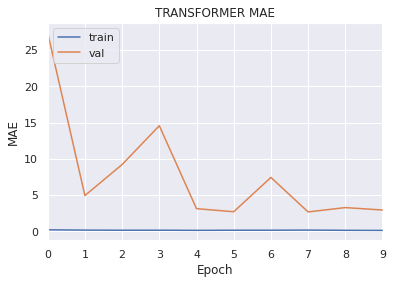

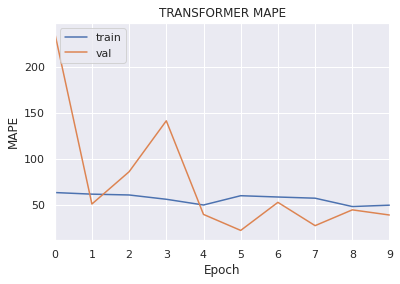

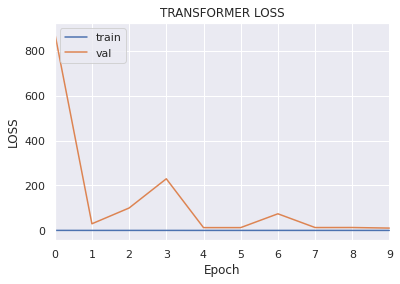

In [21]:
builder = build_model_from_hparams(build_transformer)

hparams = dict(
    fc_units=[64,64],
    embed_dim=32,
    d_k=512,
    d_v=256,
    n_heads=8,
    d_ff=512,
    optim='adam',
    lr=0.001,
)
compile_params = dict(
    loss='mse',
    metrics=['mae', 'mape'],
)

model, hist, met, hparams, df = train_evaluate_for_dataset(
    model_name='transformer',
    build_model_func=builder,
    hparams=hparams,
    compile_params=compile_params,
    asset='aapl',
    in_seq_len=128,
    out_seq_len=1,
    shift=1,
    split=(0.7, 0.2, 0.1),
    in_feat=['Open','High','Low','Close','Volume'],
    # out_feat=['Open','High','Low','Close','Volume'],
    out_feat=['Close'],
    batch_size=64,
    shuffle=True,
    strategy=tf.distribute.get_strategy(),
    epochs=10,
)